<a href="https://colab.research.google.com/github/rajbhadalia/NLP/blob/main/1_Multiclass_adapter_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'indianred'>**MultiClass Classification Using PEFT- Adapters** </font>




## Outline
1. **Setting up the Environment**: Installing necessary libraries and setting up paths.
2. **Creating Huggingface Dataset for Custom Dataset**: Understanding the structure and content of the dataset.

3. **Data Preprocessing**: Techniques to prepare the data for training, including handling different data splits and tokenization
4. **Training the Model**: Feeding data and adjusting weights.
5. **Inference**: Evaluate model on test set and making predictions.



# <font color = 'indianred'> **Setting up the Environment** </font>



In [ ]:
 # CHANGE FOLDERS AS PER YOUR SETUP
# from pathlib import Path
# if 'google.colab' in str(get_ipython()):
#     from google.colab import drive
#     drive.mount("/content/drive")
#     !pip install datasets adapters evaluate wandb accelerate -U -qq
#     base_folder = Path("/content/drive/MyDrive/data")
# else:
#     base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
# from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
# from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from pprint import pprint
import textwrap


In [ ]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/Classification/csv_files'
model_folder = base_folder/'models/nlp_fall_2023'
model_folder.mkdir(exist_ok=True)

In [ ]:
def print_wrap(text, d):
    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)

# <font color = 'indianred'> **Exploring and Understanding Dataset**

## <font color = 'indianred'> **Load Data set**
    


In [ ]:
stack_dataset = load_dataset('csv', data_files= str(data_folder /'multiclass_hw_basic_clean.csv'))

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# Assuming 'stack_dataset' is a huggingface dataset
# Select only the desired columns and rename them
selected_columns = {
    'text': stack_dataset['train']['basic_cleaned_text'],
    'label': stack_dataset['train']['Tag_Number_final']
}

# Create a new dataset with the selected columns
stack_selected_columns = Dataset.from_dict(selected_columns)


In [ ]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [ ]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
stack_selected_columns['label'][:10]

[8, 4, 3, 9, 4, 0, 3, 2, 0, 7]

In [ ]:
pprint(stack_selected_columns['text'][0])

('detail disclosure indicator on UIButton Is there a simple way to place a '
 "detail disclosure icon on a UIButton? I'm using a navigation controller and "
 'I want a button press to push a new view on the stack, so I thought a detail '
 "disclosure icon would be appropriate, but I haven't found a straightforward "
 'way to do that yet. What I have in mind is something like the "When Timer '
 'Ends" button in the Timer subview of the Clock app. ')


# <font color = 'indianred'> **Data Pre-processing**</font>

### <font color = 'indianred'> **Create train, valid, test splits** </font>

In [ ]:
# We know this information from how we created this dataset
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']

In [ ]:
# Cast the 'label' column of stack_selected_columns to the ClassLabel type with specified class names from class_names.
stack_selected_columns = stack_selected_columns.cast_column('label', ClassLabel(names = class_names))


Casting the dataset:   0%|          | 0/188878 [00:00<?, ? examples/s]

The code above modifies the label column of the stack_selected_columns data structure to represent categorical data using the class names provided in class_names. This will help us to keep the index and names mapping together.

In [ ]:
stack_selected_columns.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

In [ ]:
stack_selected_columns

Dataset({
    features: ['text', 'label'],
    num_rows: 188878
})

In [ ]:
# Split the test set into test and validation sets
# The train set should  be 60% of the daatset, valid and test should be 20% each
test_val_splits = stack_selected_columns.train_test_split(test_size=0.4, seed=42, stratify_by_column='label')
train_split= test_val_splits['train']
test_val_splits = test_val_splits['test'].train_test_split(test_size=0.5, seed=42, stratify_by_column='label')
val_split = test_val_splits['train']
test_split = test_val_splits['test']


In [ ]:
# combine train, val splits into one dataset
train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})

# create test dataset from test split
test_dataset = DatasetDict({'test': test_split})



### <font color = 'indianred'> **Create small subset for experimentation** </font>

The code below creates a new dataset, train_val_subset, with subsets of the original train_val_dataset. For each split ('train' and 'val'), it ensures an equal representation of 200 samples from each label (0-9). The balanced subsets are then stored in the respective splits of train_val_subset.

In [ ]:
train_val_subset = DatasetDict()

for split in ['train', 'val']:
  texts = []
  labels = []
  for label in range(10):
    label_texts = train_val_dataset[split].filter(lambda x: x['label'] == label)['text']
    label_subset = random.sample(list(label_texts), 200)
    texts.extend(label_subset)
    labels.extend([label]*len(label_subset))

  train_val_subset[split] = Dataset.from_dict({'text': texts, 'label': labels})

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/113326 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

Filter:   0%|          | 0/37776 [00:00<?, ? examples/s]

In [ ]:
# Retrieve the feature structures (data types and associated details) of the 'train' split from train_val_subset.
train_val_subset['train'].features


{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [ ]:
# Cast the 'label' column of the entire train_val_subset to the ClassLabel type using the provided class names from class_names.
train_val_subset = train_val_subset.cast_column('label', ClassLabel(names = class_names)) # CODE HERE


Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_val_subset['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['c#', 'java', 'php', 'javascript', 'android', 'jquery', 'c++', 'python', 'iphone', 'asp.net'], id=None)}

## <font color = 'indianred'> **Tokenization**</font>



In [ ]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

###  <font color = 'indianred'> **Create function for Tokenizer**

In [ ]:
# Define a function to tokenize the text in a batch using the predefined tokenizer.
# The text data is extracted from the "text" key of the batch.
# The function will truncate the tokenized data if it exceeds the tokenizer's maximum length.

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True)


###  <font color = 'indianred'> **Use map function to apply tokenization to all splits**

In [ ]:
# Map the tokenize_fn function over the entire train_val_subset dataset in batches.
# This will tokenize the text data in each batch and return a new dataset with tokenized data.
tokenized_dataset = train_val_subset.map(tokenize_fn, batched=True)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

We can see that tokenization step has added three new columns ('input_ids', 'token_type_ids', 'attention_mask') to the dataset

In [ ]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)

In [ ]:
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format(type='torch')

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

#  <font color = 'indianred'> **Model Training**

In [ ]:
from transformers import RobertaConfig
from adapters import AutoAdapterModel

config = RobertaConfig.from_pretrained(
    "roberta-base",
    num_labels=10,
)


In [ ]:
config

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  

###  <font color = 'indianred'> **Modify Configuration File**</font>
- We need to modify configuration fie to add ids to  label and label to ids mapping
- Adding id2label and label2id to the configuration file provides a consistent, interpretable, and user-friendly way to handle model outputs.

In [ ]:
class_names = tokenized_dataset["train"].features["labels"].names
class_names


['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

In [ ]:
id2label = {}
for id_, label_ in enumerate(class_names):
    id2label[str(id_)] = label_
id2label


{'0': 'c#',
 '1': 'java',
 '2': 'php',
 '3': 'javascript',
 '4': 'android',
 '5': 'jquery',
 '6': 'c++',
 '7': 'python',
 '8': 'iphone',
 '9': 'asp.net'}

In [ ]:
label2id = {}
for id_, label_ in enumerate(class_names):
    label2id[label_] = id_
label2id


{'c#': 0,
 'java': 1,
 'php': 2,
 'javascript': 3,
 'android': 4,
 'jquery': 5,
 'c++': 6,
 'python': 7,
 'iphone': 8,
 'asp.net': 9}

In [ ]:
config.id2label = id2label
config.label2id = label2id

In [ ]:
config


RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "c#",
    "1": "java",
    "2": "php",
    "3": "javascript",
    "4": "android",
    "5": "jquery",
    "6": "c++",
    "7": "python",
    "8": "iphone",
    "9": "asp.net"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "android": 4,
    "asp.net": 9,
    "c#": 0,
    "c++": 6,
    "iphone": 8,
    "java": 1,
    "javascript": 3,
    "jquery": 5,
    "php": 2,
    "python": 7
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size

##  <font color = 'indianred'> **Download pre-trained model**

In [ ]:
model = AutoAdapterModel.from_pretrained(
    "roberta-base",
    config=config,
)



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaAdapterModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['heads.default.3.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Add a new adapter
model.add_adapter("stack_exchange")
# Add a matching classification head
model.add_classification_head(
    "stack_exchange",
    num_labels=10,
    id2label=id2label
  )
# Activate the adapter
model.train_adapter("stack_exchange")

##  <font color = 'indianred'> **Evaluation metric(s)** </font>

### <font color = 'indianred'> **Function to compute metric** </font>



In [ ]:
# Define a function to compute evaluation metrics for sequence classification.
# The function takes in the evaluation predictions which consist of logits and true labels.
# The function calculates the macro F1 score and accuracy, and returns them as a dictionary.

def compute_metrics(eval_pred):
    # Split the evaluation predictions into logits (model predictions) and actual labels.
    logits, labels = eval_pred
    # Convert logits to class predictions by picking the class with the highest logit for each input.
    predictions = np.argmax(logits, axis=-1)

    # Load the macro F1 score metric.
    f1_metric = evaluate.load("f1", average="macro")
    # Load the accuracy metric.
    accuracy = evaluate.load("accuracy")

    # Initialize an empty dictionary to store computed metric results.
    evaluations = {}
    # Compute and store the macro F1 score.
    evaluations.update(f1_metric.compute(predictions=predictions, references=labels, average="macro"))
    # Compute and store the accuracy.
    evaluations.update(accuracy.compute(predictions=predictions, references=labels))

    return evaluations



## <font color = 'indianred'> **Set up Logger for experiments**</font>

In [ ]:
# YOU WILL NEED TO CREATE AN ACCOUNT FOR WANDB
# It may provide a link for token , copy paste the token following instructions
# setup wandb
wandb.login()  # you will need to craete wandb account first
# Set project name for logging
%env WANDB_PROJECT = nlp_2023-PartA

## <font color = 'indianred'> **Hyperparameters and Checkpointing**</font>

In [ ]:
import numpy as np
from transformers import TrainingArguments, EvalPrediction
from adapters import AdapterTrainer


In [ ]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_fall_2023/stck_exchange/peft/adapter"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=6,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=32,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=32,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    remove_unused_columns=False,

    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'stack_adapter',  # Experiment name for Weights & Biases
)


##  <font color = 'indianred'> **Initialize Trainer**</font>

In [ ]:
# initialize trainer
trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


##  <font color = 'indianred'> **Start Training**

In [ ]:
trainer.train()  # start training


## <font color = 'indianred'> **Evaluation**


### <font color = 'indianred'> **Check performance on validation set**</font>


In [ ]:
# Evaluate the trained model on the tokenized validation dataset.
# This will provide metrics like loss, accuracy, etc. based on the model's performance on the validation set.
trainer.evaluate(tokenized_dataset["val"])


{'eval_loss': 0.43032729625701904,
 'eval_f1': 0.8677917019571177,
 'eval_accuracy': 0.8665,
 'eval_runtime': 18.6109,
 'eval_samples_per_second': 107.464,
 'eval_steps_per_second': 3.385,
 'epoch': 6.0}

###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [ ]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["val"])


In [ ]:
# Retrieve the named fields (attributes) of the valid_output object.
# This helps understand the structure of the prediction output and the available information it contains.
valid_output._fields



('predictions', 'label_ids', 'metrics')

In [ ]:
# Check and print the shape of the predictions and label_ids from the valid_output object.
# This provides insight into the dimensions of the predicted outputs and the true labels for the validation set.
print(valid_output.predictions.shape)
print(valid_output.label_ids.shape)




(2000, 10)
(2000,)


In [ ]:
# Convert the logits (raw prediction scores) from the valid_output object into class predictions.
# For each input, pick the class with the highest logit as the predicted class.
# Also, extract the true label IDs from valid_output and store them as an array for further analysis.
valid_preds = np.argmax(valid_output.predictions, axis=1)
valid_labels = np.array(valid_output.label_ids)



In [ ]:
class_names = train_val_subset["val"].features["label"].names
class_names

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'asp.net']

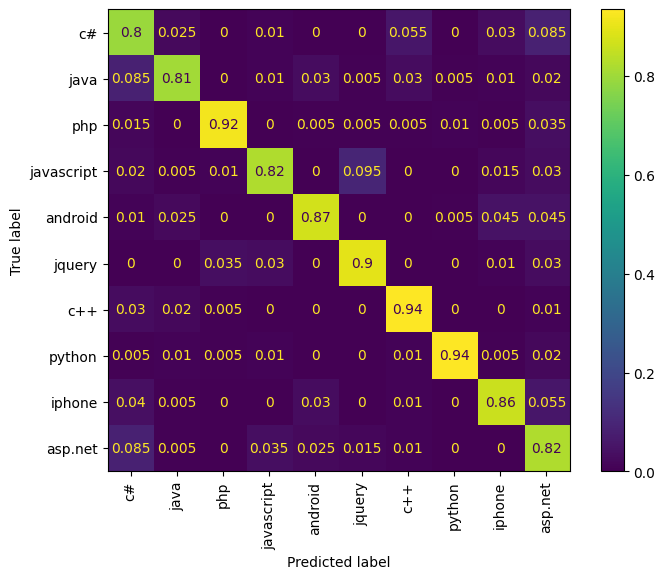

In [ ]:
# Plot a confusion matrix to visualize the model's classification performance on the validation set.
# The matrix shows the true labels versus the predicted labels.
# The matrix is normalized by the number of true samples per class, making it easier to identify misclassifications.

fig, ax = plt.subplots(figsize=(8, 6))  # Initialize a plotting figure with a specified size.

# Generate and display the confusion matrix using true labels and predicted labels.
# The matrix is normalized, and custom display labels and x-axis tick rotation are applied for better visualization.
ConfusionMatrixDisplay.from_predictions(
    y_true=valid_labels,        # Actual labels from the validation set.
    y_pred=valid_preds,         # Predicted class labels by the model.
    ax=ax,                      # Plotting axis.
    normalize="true",           # Normalize by true class counts.
    display_labels=class_names, # Custom class names for display.
    xticks_rotation=90          # Rotate x-axis ticks for better readability.
)


In [ ]:
# Log the confusion matrix to the Weights & Biases (Wandb) platform for monitoring and visualization.
# This allows for tracking the model's classification performance across different runs or iterations.

# log the Confusion Matrix to Wandb
wandb.log({
    "conf_mat": wandb.plot.confusion_matrix(
        preds=valid_preds,        # Model's predicted class labels.
        y_true=valid_labels,      # Actual labels from the validation set.
        class_names=class_names   # Custom class names for display in the confusion matrix.
    )
})



In [ ]:
wandb.finish()


### <font color = 'indianred'> **Check the best saved model**</font>


In [ ]:
# After training, let us check the best checkpoint
# We need this for Predictions and Evaluations
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")


The best model was saved at step 360.


https://docs.adapterhub.ml/quickstart.html